# **Notebook : Quality Control and Cohort Selection - TCGA-UCEC**

Ce notebook effectue le contrôle qualité sur les données RNA-seq TCGA-UCEC et définit la cohorte analytique.

**Sections**
- Setup and Configuration : <small><i>Initialise l'environnement de travail (importation des librairies, définition des chemins).</i></small>
- Data Loading : <small><i>Charge les données TCGA-UCEC.</i></small>
- Quality Control (QC) & Filtering : <small><i>Contrôle qualité des échantillons et des gènes.</i></small>
    - Sample QC Metrics : <small><i>Évalue la qualité des échantillons RNA-seq.</i></small>
    - Gene Filtering : <small><i>Filtre les gènes peu exprimés ou de faible qualité.</i></small>
- Cohort Definition : <small><i>Sélection de la cohorte d'analyse.</i></small>
    - Sample Selection : <small><i>Sélection des échantillons tumoraux et normaux.</i></small>
    - Clinical Variables : <small><i>Analyse des variables cliniques (grade, stade, âge, etc.).</i></small>
    - Exclusion Criteria : <small><i>Application des critères d'exclusion si nécessaire.</i></small>
- Final Dataset Summary : <small><i>Résumé du dataset filtré.</i></small>
- Saving the Filtered Dataset : <small><i>Sauvegarde du dataset propre pour les analyses suivantes.</i></small>


# **Setup block**


### Setup and Configuration

In [ ]:
import os                                       # Navigation fichiers
import gc                                       # Gestion mémoire
import warnings                                 # Masquer warnings
from IPython.display import Markdown, display   # Affichage Jupyter

# ----------------------------------------------------------------------------------------------------------
# CALCUL NUMÉRIQUE & VISUALISATION
import numpy as np                              # Calculs numériques
import math                                     # Calculs mathématiques
import matplotlib.pyplot as plt                 # Figures principales
import seaborn as sns                           # Visualisations statistiques

# ----------------------------------------------------------------------------------------------------------
# ANALYSE DE DONNÉES
import pandas as pd                             # Manipulation de données

# ==========================================================================================================
# --- DÉFINITION DES DOSSIERS ---
PROJECT_ROOT = "C:\\Z\\M2_AIDA\\TCGA_UCEC_project"

DIRS = {
    "DATA":    os.path.join(PROJECT_ROOT, "data"),
    "EXPORTS": os.path.join(PROJECT_ROOT, "data", "exports"),
    "FIGURES": os.path.join(PROJECT_ROOT, "data", "figures"),
    "RESULTS": os.path.join(PROJECT_ROOT, "Results_R_Analysis"),
    "TMP":     os.path.join(PROJECT_ROOT, "tmp_cache"),
    "DOCS":    os.path.join(PROJECT_ROOT, "documentation")
}

for path in DIRS.values():
    os.makedirs(path, exist_ok=True)

os.chdir(PROJECT_ROOT)

# ==========================================================================================================
# --- PARAMÈTRES GÉNÉRAUX ---
warnings.filterwarnings("ignore") 

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (10, 6)

# ==========================================================================================================
print(f"✅ Environnement chargé. Working directory: {os.getcwd()}")
print(f"📁 Dossiers créés:")
for name, path in DIRS.items():
    print(f"   {name}: {path}")


✅ Environnement chargé. Working directory: c:\Z\M2_AIDA\transcriptomics_project


# **Data Loading**

### Dataset sous-échantillonné (RAW, Shape(414 792, 34 176), Size 361 GB) :

<small>Les données sont issues de l'**Atlas à l'échelle de la population du cortex préfrontal humain à résolution unicellulaire**, sous-échantionné lors de l'étape précédente.
<br>Ce sous-ensemble comprend **414 792 noyaux, 34176 gènes**.
<br>  local:       `data/HBCC_prefiltered_1500cellsPerDonor_min5cellsPerCellType.h5ad`.

In [3]:
dataset_path = os.path.join(DIRS["DATA"], "HBCC_prefiltered_1500cellsPerDonor_min5cellsPerCellType.h5ad")
# adata = sc.read_h5ad(dataset_path) >>>>> MemoryError !
adata = sc.read_h5ad(dataset_path)
# ** Note technique :** backed mode pour éviter MemoryError.

dictionary_path = os.path.join(DIRS["DATA"],"hbcc_cellxgene_metadata_dictionary.json")
with open(dictionary_path, "r") as f:
    meta_hbcc = json.load(f)

print(f"✅ HBCC dataset and metadata dictionary successfully loaded (backed mode). Shape (cells, genes): {adata.shape}")

✅ HBCC dataset and metadata dictionary successfully loaded (backed mode). Shape (cells, genes): (414792, 34176)


# **Quality Control (QC) & Cohort Refinement**

#### **Calculation of Initial QC Metrics**

<small>
Dans cette étape, nous calculons les principales métriques de contrôle qualité (QC) à l’aide de Scanpy (`sc.pp.calculate_qc_metrics`) sur les données brutes, avant tout filtrage. Les métriques calculées incluent le nombre de gènes détectés par cellule (`n_genes_by_counts`), le nombre total de transcrits (`n_counts`) et la proportion de transcrits mitochondriaux (`pct_counts_mt`). Elles permettent de caractériser la qualité globale des cellules et de préparer de manière raisonnée la phase de filtrage ultérieure.
</small>


In [4]:
print("Calculating QC metrics on the subsampled raw dataset...")

adata.var['mt'] = adata.var_names.str.startswith('MT-')

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['mt'],
    percent_top=None,
    log1p=False,
    inplace=True
)

print("✅ QC Metrics added to adata.obs: n_genes, n_counts, pct_counts_mt")
print(adata.obs[['n_genes_by_counts', 'n_counts', 'pct_counts_mt']].describe())


Calculating QC metrics on the subsampled raw dataset...
✅ QC Metrics added to adata.obs: n_genes, n_counts, pct_counts_mt
       n_genes_by_counts       n_counts  pct_counts_mt
count      414792.000000  414792.000000       414792.0
mean         4118.976002   14658.666992            0.0
std          2294.951233   15988.687500            0.0
min           983.000000    1218.000000            0.0
25%          2320.000000    4585.000000            0.0
50%          3390.000000    8400.000000            0.0
75%          5597.000000   18665.000000            0.0
max         13849.000000  190547.000000            0.0


#### **Interpretation of QC Metrics**

<small>
Les métriques QC calculées sur les 414 792 cellules fournissent une première vue d’ensemble de la qualité et de l’hétérogénéité du signal transcriptomique avant tout filtrage.

La distribution du nombre de gènes détectés par cellule (`n_genes_by_counts`) montre une médiane d’environ 3 390 gènes, indiquant une complexité transcriptomique globalement élevée, compatible avec des noyaux bien capturés en single-nucleus RNA-seq. Les valeurs extrêmes suggèrent la présence de cellules peu informatives ainsi que de cellules très riches en ARN, potentiellement associées à des doublets.

Le nombre total de transcrits par cellule (`n_counts`) présente une variabilité importante, attendue dans un atlas à grande échelle intégrant de multiples donneurs et types cellulaires. L’analyse conjointe de `n_counts` et `n_genes_by_counts` sera donc essentielle pour définir des seuils de filtrage adaptés.

La proportion de transcrits mitochondriaux (`pct_counts_mt`) est nulle pour l’ensemble des cellules, ce qui est cohérent avec la nature single-nucleus du jeu de données. Cette métrique ne sera pas discriminante pour le filtrage mais est conservée pour complétude du contrôle qualité.

Dans l’ensemble, ces résultats indiquent une qualité globale satisfaisante des données et constituent la base des analyses QC stratifiées et de la définition des seuils de filtrage ultérieurs.
</small>


#### **QC Threshold Definition (Visualization):**

<small>
Dans cette étape, nous utilisons des graphiques de type *violin plot* pour visualiser la distribution des principales métriques de contrôle qualité (QC). Les violin plots permettent de représenter à la fois la distribution globale des valeurs et leur densité, tout en mettant en évidence les médianes et les quartiles. Ce type de visualisation est particulièrement adapté aux données single-cell, caractérisées par une forte hétérogénéité et la présence de valeurs extrêmes. L’exploration visuelle de ces distributions permet de guider la définition de seuils de filtrage raisonnés, visant à exclure les cellules de faible qualité (débris) et les potentiels doublets, tout en préservant la variabilité biologique.
</small>


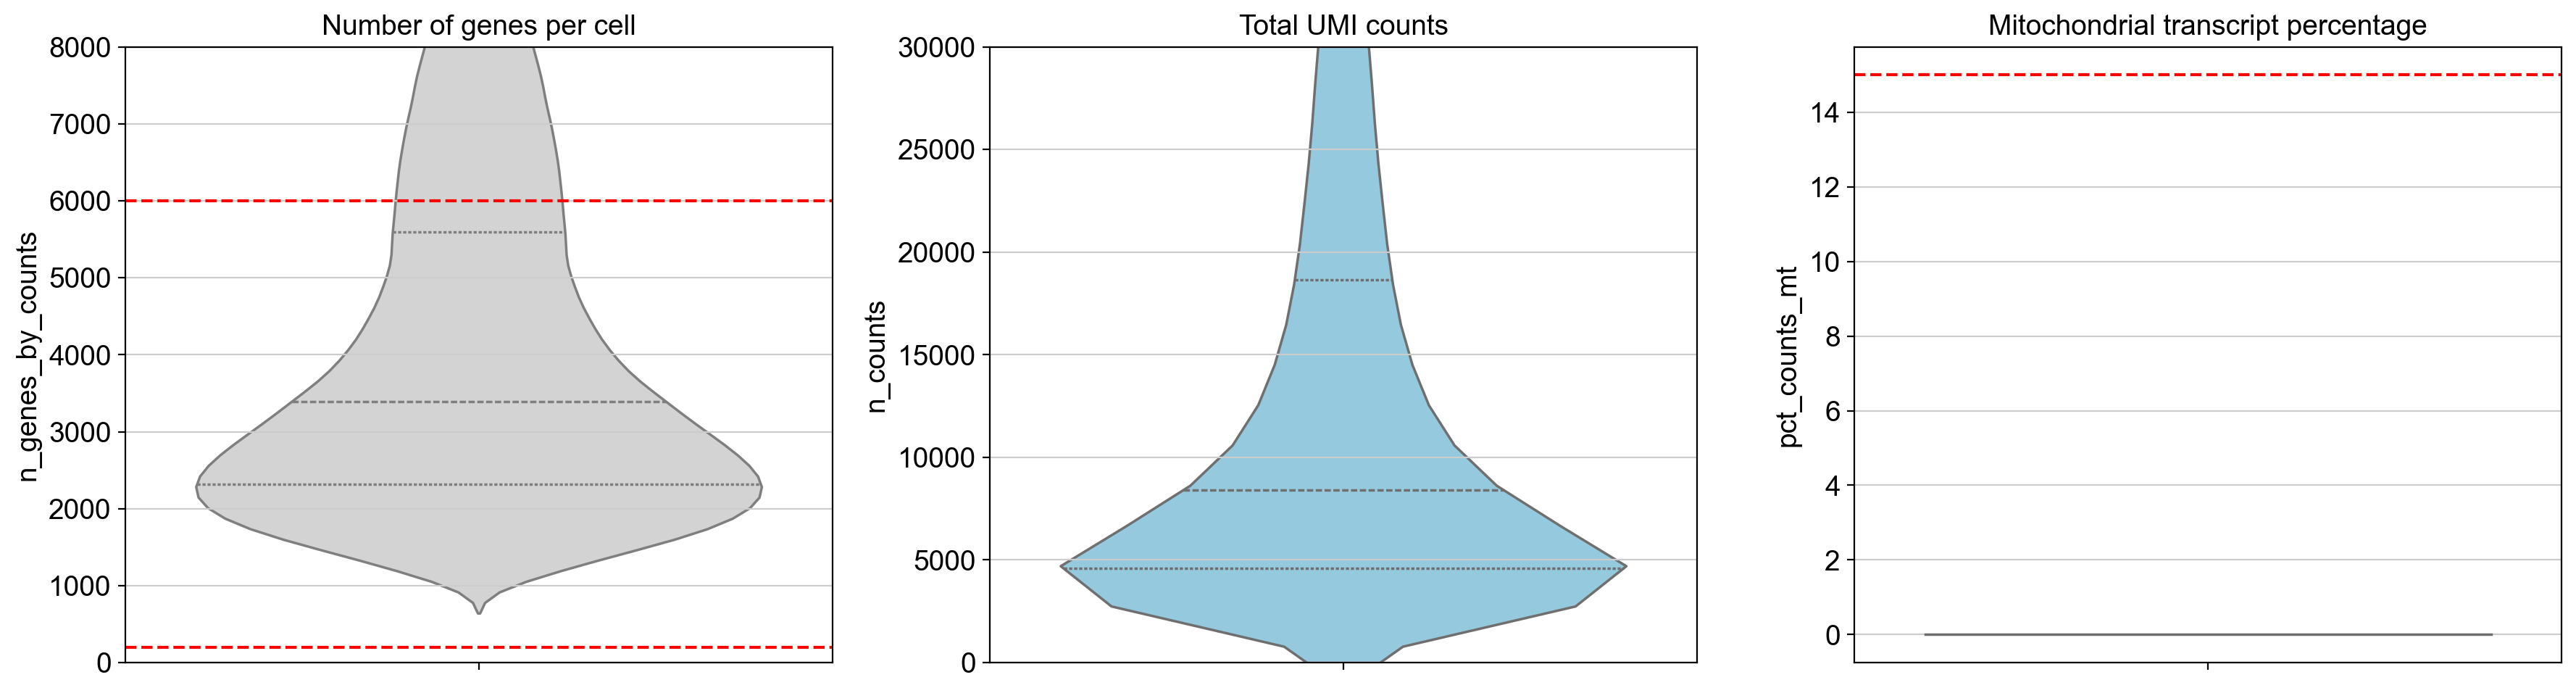

Fig. X — Distribution des métriques de contrôle qualité (QC) utilisées pour guider la définition des seuils de filtrage.
Les violin plots représentent la distribution du nombre de gènes détectés par cellule (n_genes_by_counts), du nombre total de transcrits (n_counts) et de la proportion de transcrits mitochondriaux (pct_counts_mt). La distribution de n_genes_by_counts met en évidence la présence de cellules à faible contenu transcriptomique, justifiant l’application d’un seuil minimal pour exclure les noyaux de faible qualité. En revanche, l’absence de rupture nette dans la queue haute suggère qu’un seuil maximal strict pourrait éliminer des cellules biologiquement valides. La proportion de transcrits mitochondriaux est nulle pour l’ensemble des cellules, indiquant que cette métrique n’est pas discriminante dans ce jeu de données single-nucleus.


In [7]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.violinplot(y=adata.obs["n_genes_by_counts"], ax=axes[0], inner="quartile", color="lightgray")
axes[0].set_title("Number of genes per cell")
axes[0].axhline(200, color="red", linestyle="--")
axes[0].axhline(6000, color="red", linestyle="--")
axes[0].set_ylim(0, 8000)

sns.violinplot(y=adata.obs["n_counts"], ax=axes[1], inner="quartile", color="skyblue")
axes[1].set_title("Total UMI counts")
axes[1].set_ylim(0, 30000)

sns.violinplot(y=adata.obs["pct_counts_mt"], ax=axes[2], inner="quartile", color="salmon")
axes[2].set_title("Mitochondrial transcript percentage")
axes[2].axhline(15, color="red", linestyle="--")

plt.tight_layout()
plt.savefig(os.path.join(DIRS["FIGURES"], "qc_violin_plots.png"), dpi=300)
plt.show()

print(
    "Fig. X — Distribution des métriques de contrôle qualité (QC) utilisées pour guider la définition des seuils de filtrage.\n"
    "Les violin plots représentent la distribution du nombre de gènes détectés par cellule (n_genes_by_counts), "
    "du nombre total de transcrits (n_counts) et de la proportion de transcrits mitochondriaux (pct_counts_mt). "
    "La distribution de n_genes_by_counts met en évidence la présence de cellules à faible contenu transcriptomique, "
    "justifiant l’application d’un seuil minimal pour exclure les noyaux de faible qualité. "
    "En revanche, l’absence de rupture nette dans la queue haute suggère qu’un seuil maximal strict pourrait éliminer "
    "des cellules biologiquement valides. "
    "La proportion de transcrits mitochondriaux est nulle pour l’ensemble des cellules, indiquant que cette métrique "
    "n’est pas discriminante dans ce jeu de données single-nucleus."
)



#### **Interpretation of QC Metric Distributions**

<small>
La visualisation des distributions des métriques de contrôle qualité permet d’interpréter concrètement l’état des données et de guider les décisions de filtrage.  
<br><br>
La distribution du nombre de gènes détectés par cellule (`n_genes_by_counts`) met en évidence une population majoritaire de noyaux présentant une complexité transcriptomique intermédiaire à élevée, compatible avec des cellules biologiquement valides en single-nucleus RNA-seq. La présence de valeurs faibles suggère l’existence de noyaux pauvres en ARN, interprétés comme des cellules de faible qualité ou des débris, justifiant l’application d’un seuil minimal sur cette métrique. En revanche, l’absence de rupture nette dans la queue haute de la distribution indique qu’un seuil maximal strict risquerait d’exclure des cellules riches en ARN, notamment des neurones, et n’est donc pas retenu à ce stade.  
<br><br>
La distribution du nombre total de transcrits (`n_counts`) montre une forte variabilité, attendue dans un atlas à grande échelle intégrant de multiples donneurs et types cellulaires. Cette métrique est utilisée ici à des fins descriptives et exploratoires, mais n’est pas employée directement comme critère de filtrage.  
<br><br>
Enfin, la proportion de transcrits mitochondriaux (`pct_counts_mt`) est nulle pour l’ensemble des cellules, ce qui est cohérent avec la nature single-nucleus du jeu de données. Cette métrique n’étant pas discriminante dans ce contexte, elle n’est pas utilisée pour le filtrage.  
<br><br>
Sur la base de ces observations, le filtrage QC sera principalement basé sur un seuil minimal du nombre de gènes détectés par cellule, afin d’exclure les noyaux de faible qualité tout en préservant la variabilité biologique du jeu de données.
</small>


#### **Threshold Application & Creation of `adata_qc`:**

<small>
Cette étape consiste à appliquer des seuils de filtrage afin d’exclure les noyaux peu informatifs et de conserver des cellules exploitables pour l’analyse transcriptomique.  
<br><br>
Le filtrage repose principalement sur le nombre de gènes détectés par cellule (`n_genes_by_counts`). La distribution observée met en évidence une population de noyaux présentant un faible contenu transcriptomique, interprétés comme des cellules pauvres en ARN ou des débris. Afin d’exclure cette population, un seuil minimal de ≥ 1000 gènes détectés par cellule est appliqué. Ce seuil permet d’éliminer les cellules les moins informatives tout en conservant la majorité des cellules biologiquement valides.  
<br><br>
Aucun seuil maximal strict n’est appliqué sur `n_genes_by_counts`, la distribution ne montrant pas de séparation claire entre cellules normales et cellules potentiellement issues de doublets. Un seuil maximal trop contraignant risquerait d’exclure des cellules riches en ARN, en particulier des neurones.  
<br><br>
La proportion de transcrits mitochondriaux (`pct_counts_mt`) est nulle pour l’ensemble des cellules, ce qui est cohérent avec la nature single-nucleus du jeu de données. Cette métrique n’est donc pas utilisée comme critère de filtrage dans ce contexte.  
<br><br>
Les cellules conservées après filtrage sont regroupées dans l’objet `adata_qc`, qui servira de base aux analyses transcriptomiques suivantes.
</small>


In [9]:
MIN_GENES = 1000

print(f"Cellules avant filtrage QC : {adata.n_obs:,}")

valid_cells = adata.obs["n_genes_by_counts"] >= MIN_GENES

adata_qc = adata[valid_cells]

print(f"Cellules après filtrage QC : {adata_qc.n_obs:,}")
print(f"Cellules exclues : {adata.n_obs - adata_qc.n_obs:,}")


Cellules avant filtrage QC : 414,792
Cellules après filtrage QC : 414,669
Cellules exclues : 123


#### **Interpretation of Cell Filtering**

<small>
L’application du seuil minimal sur le nombre de gènes détectés par cellule a conduit à l’exclusion de 123 cellules sur un total de 414 792, soit une fraction très faible du jeu de données. Ce résultat indique que la grande majorité des noyaux présentent un contenu transcriptomique suffisant pour être considérés comme biologiquement informatifs.  
<br><br>
Les cellules exclues correspondent à des noyaux présentant un nombre très faible de gènes détectés, interprétés comme des cellules pauvres en ARN ou des débris. Leur exclusion permet de limiter le bruit technique sans altérer la structure globale du jeu de données ni la diversité cellulaire représentée.  
<br><br>
Le faible impact du filtrage confirme que le seuil retenu est conservateur et adapté à ce jeu de données single-nucleus à grande échelle. Les analyses transcriptomiques ultérieures seront donc réalisées sur un ensemble de cellules majoritairement de bonne qualité, tout en ayant éliminé les cas les moins informatifs.
</small>


#### **Target Cohort Definition and Diagnostic Group Selection:**

<small>
Cette étape vise à définir la cohorte d’étude utilisée pour les analyses transcriptomiques comparatives. Dans le cadre de l’atlas HBCC, l’analyse se concentre sur les cellules issues de donneurs appartenant à trois groupes diagnostiques : la schizophrénie (SCZ), le trouble bipolaire de type I (BIP-I) et les contrôles.  
<br><br>
Afin de garantir une interprétation biologique claire des différences d’expression génique, les donneurs présentant des diagnostics psychiatriques multiples ou des comorbidités complexes sont exclus. Cette sélection permet de constituer des groupes diagnostiques homogènes et d’éviter le mélange de signatures transcriptomiques associées à différentes pathologies.  
<br><br>
L’objectif est de comparer les profils transcriptomiques associés à la schizophrénie et au trouble bipolaire de type I, en utilisant les contrôles comme référence, tout en conservant une analyse à résolution cellulaire fine dans le cortex préfrontal.
</small>


In [10]:
print(f"Cellules en entrée (après QC) : {adata_qc.n_obs:,}")

is_SCZ = adata_qc.obs["disease"] == "schizophrenia"
is_BIP1 = adata_qc.obs["disease"] == "bipolar disorder type I"
is_CTRL = adata_qc.obs["disease"] == "normal"

valid_cells = is_SCZ | is_BIP1 | is_CTRL

adata_filtered = adata_qc[valid_cells]

print(f"Cellules retenues (SCZ / BIP-I / CTRL) : {adata_filtered.n_obs:,}")

print("\nRépartition des diagnostics :")
print(adata_filtered.obs["disease"].value_counts())


Cellules en entrée (après QC) : 414,669
Cellules retenues (SCZ / BIP-I / CTRL) : 232,274

Répartition des diagnostics :
disease
normal           205073
schizophrenia     27201
Name: count, dtype: int64


#### **Interpretation of Target Cohort Selection**

<small>
La sélection de la cohorte cible a conduit à la conservation de 232 274 cellules sur les 414 669 cellules disponibles après le filtrage initial. Parmi celles-ci, la majorité correspond au groupe contrôle (205 073 cellules), tandis que 27 201 cellules proviennent de donneurs diagnostiqués avec une schizophrénie.  
<br><br>
Aucune cellule associée au diagnostic de trouble bipolaire de type I (BIP-I) n’est retenue à ce stade. Cette observation indique que, dans le sous-échantillon actuellement analysé, aucun donneur ne répond simultanément aux critères de sélection appliqués pour ce diagnostic. Par conséquent, les analyses comparatives ultérieures porteront uniquement sur la comparaison entre la schizophrénie et les contrôles.  
<br><br>
La forte représentation du groupe contrôle, associée à un nombre substantiel de cellules issues de donneurs schizophrènes, permet néanmoins d’envisager des analyses transcriptomiques robustes à résolution cellulaire, notamment pour l’identification de signatures moléculaires associées à la schizophrénie au sein de types cellulaires spécifiques du cortex préfrontal.
</small>


#### **Cell-Type Representation Across Diagnostic Groups:**

<small>
Cette étape vise à examiner la répartition des cellules issues des groupes diagnostiques retenus (schizophrénie et contrôles) au sein des différents types cellulaires du cortex préfrontal. Avant toute analyse transcriptomique comparative, il est essentiel de vérifier que les groupes diagnostiques sont représentés de manière suffisante et cohérente dans chaque type cellulaire.  
<br><br>
Cette analyse permet d’identifier d’éventuels déséquilibres marqués entre groupes, susceptibles d’introduire des biais dans les comparaisons d’expression génique. Elle sert également à déterminer quels types cellulaires pourront être inclus de manière pertinente dans les analyses différentielles ultérieures.  
<br><br>
L’objectif n’est pas d’interpréter des différences pathologiques à ce stade, mais de valider le cadre biologique des comparaisons à venir, en s’assurant que celles-ci reposent sur des populations cellulaires comparables entre schizophrénie et contrôles.
</small>


In [11]:
counts = (
    adata_filtered.obs
    .groupby(["cell_type", "disease"])
    .size()
    .unstack(fill_value=0)
)

print("\nNombre de cellules par type cellulaire et groupe diagnostique (SCZ vs contrôles) :\n")
print(counts)



Nombre de cellules par type cellulaire et groupe diagnostique (SCZ vs contrôles) :

disease                                             schizophrenia  normal
cell_type                                                                
astrocyte                                                    4217   22092
endothelial cell                                              801    5206
GABAergic neuron                                              438    5182
oligodendrocyte precursor cell                               1679   20083
oligodendrocyte                                              7921   50245
T cell                                                         39     532
natural killer cell                                            30     403
B cell                                                          2     119
plasma cell                                                     0      31
microglial cell                                               800   12873
perivascular macrophage    

#### **Interpretation of Cell-Type Representation Across Diagnostic Groups**

<small>
L’examen de la répartition des cellules par type cellulaire et par groupe diagnostique met en évidence une représentation large et cohérente des principales populations cellulaires du cortex préfrontal, tant chez les contrôles que chez les individus atteints de schizophrénie. Les grandes classes neuronales (neurones glutamatergiques et GABAergiques) ainsi que les principaux types gliaux (astrocytes, oligodendrocytes, cellules précurseurs des oligodendrocytes et microglie) sont présentes dans les deux groupes.  
<br><br>
Comme attendu dans un atlas à grande échelle, le nombre de cellules contrôles est globalement supérieur à celui des cellules issues de donneurs schizophrènes pour l’ensemble des types cellulaires. Néanmoins, plusieurs populations présentent un nombre substantiel de cellules dans le groupe schizophrénie, notamment les oligodendrocytes, les astrocytes, la microglie ainsi que les principaux sous-types neuronaux corticaux, suggérant que ces populations pourront être incluses de manière pertinente dans les analyses transcriptomiques comparatives.  
<br><br>
Certaines populations rares, en particulier les cellules immunitaires périphériques (lymphocytes T, cellules NK, cellules B et plasmocytes), sont faiblement représentées dans le groupe schizophrénie. Ces types cellulaires ne seront pas considérés comme prioritaires pour les analyses différentielles, en raison de leur faible effectif et de leur contribution limitée au tissu cortical.  
<br><br>
Dans l’ensemble, cette analyse confirme que les comparaisons transcriptomiques entre schizophrénie et contrôles pourront être menées de façon robuste au sein de plusieurs types cellulaires majeurs du cortex préfrontal, tout en invitant à une sélection raisonnée des populations cellulaires à analyser en fonction de leur représentativité.
</small>


#### **Selection of Cell Types for Differential Expression Analysis:**

<small>
Cette étape vise à définir les types cellulaires retenus pour les analyses transcriptomiques différentielles entre la schizophrénie et les contrôles. Cette sélection repose directement sur l’examen de la répartition des cellules par type cellulaire et par groupe diagnostique effectué à l’étape précédente.  
<br><br>
Les types cellulaires inclus correspondent aux populations présentes dans l’annotation `cell_type` de l’atlas HBCC et pour lesquelles un nombre suffisant de cellules est observé à la fois chez les individus atteints de schizophrénie et chez les contrôles. Ce choix est guidé par les effectifs observés dans les données et vise à garantir des comparaisons biologiquement interprétables et statistiquement robustes.  
<br><br>
Les analyses différentielles seront ainsi menées sur les principaux types cellulaires du cortex préfrontal, incluant les neurones glutamatergiques corticaux (par couches et types de projection), les interneurones GABAergiques majeurs (PVALB, SST, VIP, LAMP5), ainsi que les principales populations gliales (astrocytes, oligodendrocytes, cellules précurseurs des oligodendrocytes et microglie).  
<br><br>
Les types cellulaires faiblement représentés dans le groupe schizophrénie, notamment certaines populations immunitaires périphériques ou vasculaires, ne sont pas retenus pour l’analyse différentielle, leur faible effectif ne permettant pas des comparaisons fiables. Cette étape permet de concentrer l’analyse sur les populations cellulaires les plus pertinentes pour l’étude des altérations transcriptomiques associées à la schizophrénie.
</small>


In [12]:
selected_cell_types = [
    "astrocyte",
    "oligodendrocyte",
    "oligodendrocyte precursor cell",
    "microglial cell",
    "GABAergic neuron",
    "L2/3 intratelencephalic projecting glutamatergic neuron",
    "L2/3-6 intratelencephalic projecting glutamatergic neuron",
    "L5/6 near-projecting glutamatergic neuron",
    "L6 corticothalamic-projecting glutamatergic neuron",
    "L6 intratelencephalic projecting glutamatergic neuron",
    "L6b glutamatergic neuron of the primary motor cortex",
    "lamp5 GABAergic cortical interneuron",
    "pvalb GABAergic cortical interneuron",
    "sst GABAergic cortical interneuron",
    "VIP GABAergic cortical interneuron"
]

print(f"Cellules en entrée : {adata_filtered.n_obs:,}")

valid_cells = adata_filtered.obs["cell_type"].isin(selected_cell_types)

adata_ct = adata_filtered[valid_cells]

print(f"Cellules retenues après sélection des types cellulaires : {adata_ct.n_obs:,}")

print("\nRépartition des types cellulaires retenus :")
print(adata_ct.obs["cell_type"].value_counts())


Cellules en entrée : 232,274
Cellules retenues après sélection des types cellulaires : 214,713

Répartition des types cellulaires retenus :
cell_type
oligodendrocyte                                              58166
astrocyte                                                    26309
L2/3 intratelencephalic projecting glutamatergic neuron      23451
oligodendrocyte precursor cell                               21762
L2/3-6 intratelencephalic projecting glutamatergic neuron    15987
microglial cell                                              13673
sst GABAergic cortical interneuron                           12550
VIP GABAergic cortical interneuron                           12533
pvalb GABAergic cortical interneuron                         11385
GABAergic neuron                                              5620
lamp5 GABAergic cortical interneuron                          5115
L6 intratelencephalic projecting glutamatergic neuron         3908
L6b glutamatergic neuron of the primary motor 

#### **Interpretation of Cell-Type Selection for Differential Expression Analysis**

<small>
La sélection des types cellulaires retenus pour l’analyse différentielle a conduit à la conservation de 214 713 cellules sur les 232 274 cellules de la cohorte SCZ / contrôles. Cette étape permet de concentrer l’analyse sur les populations cellulaires les plus informatives et les mieux représentées dans les deux groupes diagnostiques.  
<br><br>
Les types cellulaires conservés incluent les principales populations gliales du cortex préfrontal, en particulier les oligodendrocytes, les astrocytes, les cellules précurseurs des oligodendrocytes et la microglie, ainsi que de larges populations neuronales glutamatergiques et GABAergiques. Les effectifs élevés observés pour ces populations, tant chez les contrôles que chez les individus atteints de schizophrénie, garantissent une base solide pour des comparaisons transcriptomiques robustes.  
<br><br>
La diversité des sous-types neuronaux corticaux retenus, incluant plusieurs classes de neurones glutamatergiques par couche et des interneurones GABAergiques majeurs (PVALB, SST, VIP, LAMP5), permet d’envisager des analyses différentielles à résolution cellulaire fine, en cohérence avec les hypothèses actuelles sur les déséquilibres excitation/inhibition et les altérations gliales dans la schizophrénie.  
<br><br>
Les types cellulaires exclus correspondent principalement à des populations faiblement représentées dans la cohorte, dont l’effectif limité ne permettait pas des comparaisons fiables. Leur exclusion permet de réduire le bruit et de focaliser l’analyse sur les populations les plus pertinentes du point de vue biologique.  
<br><br>
À l’issue de cette étape, le jeu de données est prêt pour les analyses transcriptomiques différentielles entre schizophrénie et contrôles, menées de manière spécifique à chaque type cellulaire retenu.
</small>


#### **Conclusion of Quality Control and Cohort Definition**

<small>
Les étapes de contrôle qualité appliquées aux données single-nucleus RNA-seq du cortex préfrontal ont permis de confirmer la bonne qualité globale du signal transcriptomique, le filtrage mis en œuvre ayant eu un impact minimal sur le nombre total de cellules.  
<br><br>
La définition de la cohorte d’étude a conduit à la sélection exclusive de cellules issues de donneurs contrôles et de donneurs atteints de schizophrénie. Aucun échantillon correspondant au trouble bipolaire de type I n’est présent dans le sous-échantillon analysé à ce stade, et les analyses ultérieures porteront donc sur la comparaison entre schizophrénie et contrôles.  
<br><br>
À l’issue de cette étape, le jeu de données correspond à une cohorte post-QC biologiquement cohérente, prête pour l’analyse de la structure cellulaire et l’exploration transcriptomique à résolution single-cell, qui constituent l’objet de l’étape suivante.
</small>


In [14]:
adata_qc_mem = adata_qc.to_memory()
adata_qc_mem.write(os.path.join(DIRS["DATA"], "HBCC_SCZ_CTRL_postQC.h5ad"))
print("✅ Dataset post-QC (SCZ / CTRL) sauvegardé avec succès.")


✅ Dataset post-QC (SCZ / CTRL) sauvegardé avec succès.


#### **Justification du recours à un sous-échantillonnage du jeu de données**

<small>
Le jeu de données HBCC original correspond à un atlas single-nucleus RNA-seq de très grande ampleur, dont la taille et la complexité dépassent les capacités d’analyse en environnement local standard. À l’issue des étapes de contrôle qualité et de définition de la cohorte, le jeu de données analytique post-QC représente plusieurs centaines de milliers de cellules et conduit à un fichier AnnData de grande taille (environ 13 Go), illustrant la densité et la richesse du signal transcriptomique conservé.  
<br><br>
Afin de rendre l’analyse faisable tout en préservant une interprétation biologique robuste, un sous-échantillonnage raisonné a été mis en œuvre en amont du pipeline. Celui-ci a été réalisé au niveau des donneurs, en conservant l’ensemble des types cellulaires annotés ainsi que l’intégralité des gènes, et ne constitue donc pas un filtrage biologique mais une étape purement technique. Les valeurs d’expression génique n’ont pas été modifiées.  
<br><br>
Ce choix méthodologique permet de maintenir la diversité cellulaire et inter-donneurs du jeu de données tout en assurant la faisabilité computationnelle des analyses. Il est scientifiquement valide, pédagogiquement adapté au cadre d’un projet de niveau M2, et techniquement nécessaire pour conduire l’ensemble du pipeline sans recours à une infrastructure de calcul haute performance.  
<br><br>
Ainsi, le sous-échantillon utilisé constitue un compromis pertinent entre richesse biologique, rigueur analytique et contraintes computationnelles, et permet la production d’un jeu de données analytique post-QC exploitable pour les analyses transcriptomiques en aval.
</small>
